In [1]:
# Cell 1: Imports, Hyperparameters, and Seed Setup

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import random
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Set device (Kaggle T4 GPU is used if available)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Hyperparameters
NUM_EPOCHS = 75
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
LATENT_DIM = 64             # Dimension of VAE latent space
RESNET_FEATURE_DIM = 512    # Feature dimension from ResNet18
BETA = 1.0                  # Weight for KL Divergence loss
GAMMA = 1.0                 # Weight for Reconstruction loss
ALPHA = 1.0                 # Weight for Feature Matching loss
DROPOUT_P = 0.5             # Dropout probability
WEIGHT_DECAY = 1e-5         # Weight decay for regularization

# SentenceTransformer model for attribute extraction
ST_MODEL_NAME = 'all-MiniLM-L6-v2'

# CIFAR-10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Split classes into Seen and Unseen (example: 6 classes for training, 4 for testing)
ALL_CLASSES = list(range(10))
random.shuffle(ALL_CLASSES)
SEEN_CLASSES = sorted(ALL_CLASSES[:6])
UNSEEN_CLASSES = sorted(ALL_CLASSES[6:])
print(f"Seen Classes: {SEEN_CLASSES}")
print(f"Unseen Classes: {UNSEEN_CLASSES}")


Using device: cuda
Seen Classes: [2, 3, 5, 6, 7, 8]
Unseen Classes: [0, 1, 4, 9]


In [2]:
# Cell 2: Data Preparation with Augmentation and Dataset Splitting

# Define transformations for training (with augmentation) and testing (resize + normalization)
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 datasets
train_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Function to get indices for specific classes
def get_indices(dataset, classes):
    indices = []
    for i, (_, label) in enumerate(dataset):
        if label in classes:
            indices.append(i)
    return indices

# Get training indices for seen classes and split into train and validation sets
seen_train_indices = get_indices(train_dataset_full, SEEN_CLASSES)
split = int(0.8 * len(seen_train_indices))
train_indices = seen_train_indices[:split]
val_indices = seen_train_indices[split:]
train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(train_dataset_full, val_indices)

# Prepare test datasets for seen and unseen classes
test_seen_indices = get_indices(test_dataset_full, SEEN_CLASSES)
test_unseen_indices = get_indices(test_dataset_full, UNSEEN_CLASSES)
test_seen_dataset = Subset(test_dataset_full, test_seen_indices)
test_unseen_dataset = Subset(test_dataset_full, test_unseen_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_seen_loader = DataLoader(test_seen_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_unseen_loader = DataLoader(test_unseen_dataset, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Cell 3: Attribute Extraction Using SentenceTransformer

print("Loading Sentence Transformer model for attribute extraction...")
st_model = SentenceTransformer(ST_MODEL_NAME, device=DEVICE)
ATTRIBUTE_DIM = st_model.get_sentence_embedding_dimension()
print(f"Attribute embedding dimension: {ATTRIBUTE_DIM}")

# Encode CIFAR-10 class names to obtain attribute embeddings
class_attributes = {}
print("Encoding class names to obtain attribute embeddings...")
with torch.no_grad():
    embeddings = st_model.encode(CIFAR10_CLASSES, convert_to_tensor=True)
for i, cls_name in enumerate(CIFAR10_CLASSES):
    class_attributes[i] = embeddings[i]

# Function to obtain attribute embeddings for a batch of labels
def get_attributes(labels):
    batch_attrs = torch.stack([class_attributes[int(lbl)] for lbl in labels])
    return batch_attrs.to(DEVICE)


Loading Sentence Transformer model for attribute extraction...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Attribute embedding dimension: 384
Encoding class names to obtain attribute embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Cell 4: Feature Extractor (Pretrained ResNet18)

print("Loading pre-trained ResNet18 as feature extractor...")
resnet18 = torchvision.models.resnet18(pretrained=True)
# Remove the final fully connected layer
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])
resnet18.eval()
resnet18.to(DEVICE)

# Function to extract features from images using ResNet18
def extract_features(x):
    with torch.no_grad():
        feats = resnet18(x).view(x.size(0), -1)
    return feats


Loading pre-trained ResNet18 as feature extractor...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [5]:
# Cell 5: Conditional VAE Model Definition with Dropout and DataParallel

class ConditionalVAE(nn.Module):
    def __init__(self, feature_dim, attribute_dim, latent_dim, dropout_p=DROPOUT_P):
        super(ConditionalVAE, self).__init__()
        self.feature_dim = feature_dim
        self.attribute_dim = attribute_dim
        self.latent_dim = latent_dim
        
        # Encoder layers with dropout
        self.fc_enc1 = nn.Linear(feature_dim + attribute_dim, 512)
        self.dropout1 = nn.Dropout(dropout_p)
        self.fc_enc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_p)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder layers with dropout
        self.fc_dec1 = nn.Linear(latent_dim + attribute_dim, 256)
        self.dropout3 = nn.Dropout(dropout_p)
        self.fc_dec2 = nn.Linear(256, 512)
        self.dropout4 = nn.Dropout(dropout_p)
        self.fc_dec3 = nn.Linear(512, feature_dim)
    
    def encode(self, x, attr):
        combined = torch.cat([x, attr], dim=1)
        h = F.relu(self.fc_enc1(combined))
        h = self.dropout1(h)
        h = F.relu(self.fc_enc2(h))
        h = self.dropout2(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, attr):
        combined = torch.cat([z, attr], dim=1)
        h = F.relu(self.fc_dec1(combined))
        h = self.dropout3(h)
        h = F.relu(self.fc_dec2(h))
        h = self.dropout4(h)
        recon = self.fc_dec3(h)
        return recon
    
    def forward(self, x, attr):
        mu, logvar = self.encode(x, attr)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, attr)
        return recon, mu, logvar

# Instantiate the VAE model
vae = ConditionalVAE(feature_dim=RESNET_FEATURE_DIM, attribute_dim=ATTRIBUTE_DIM, latent_dim=LATENT_DIM).to(DEVICE)

# Wrap model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel.")
    vae = nn.DataParallel(vae)


Using 2 GPUs with DataParallel.


Starting VAE training...
Epoch [1/75] - Train Loss: 1.7755 (R:0.8821, K:0.0114, F:0.8821) - Val Loss: 1.0780 (R:0.5382, K:0.0016, F:0.5382)
Epoch [2/75] - Train Loss: 1.1485 (R:0.5732, K:0.0020, F:0.5732) - Val Loss: 0.9799 (R:0.4892, K:0.0015, F:0.4892)
Epoch [3/75] - Train Loss: 1.0704 (R:0.5335, K:0.0034, F:0.5335) - Val Loss: 0.9469 (R:0.4721, K:0.0026, F:0.4721)
Epoch [4/75] - Train Loss: 1.0124 (R:0.5039, K:0.0045, F:0.5039) - Val Loss: 0.9114 (R:0.4537, K:0.0040, F:0.4537)
Epoch [5/75] - Train Loss: 0.9742 (R:0.4846, K:0.0049, F:0.4846) - Val Loss: 0.8899 (R:0.4428, K:0.0042, F:0.4428)
Epoch [6/75] - Train Loss: 0.9444 (R:0.4696, K:0.0052, F:0.4696) - Val Loss: 0.8690 (R:0.4322, K:0.0045, F:0.4322)
Epoch [7/75] - Train Loss: 0.9255 (R:0.4599, K:0.0056, F:0.4599) - Val Loss: 0.8551 (R:0.4252, K:0.0047, F:0.4252)
Epoch [8/75] - Train Loss: 0.9156 (R:0.4549, K:0.0058, F:0.4549) - Val Loss: 0.8528 (R:0.4242, K:0.0045, F:0.4242)
Epoch [9/75] - Train Loss: 0.9062 (R:0.4501, K:0.0060, 

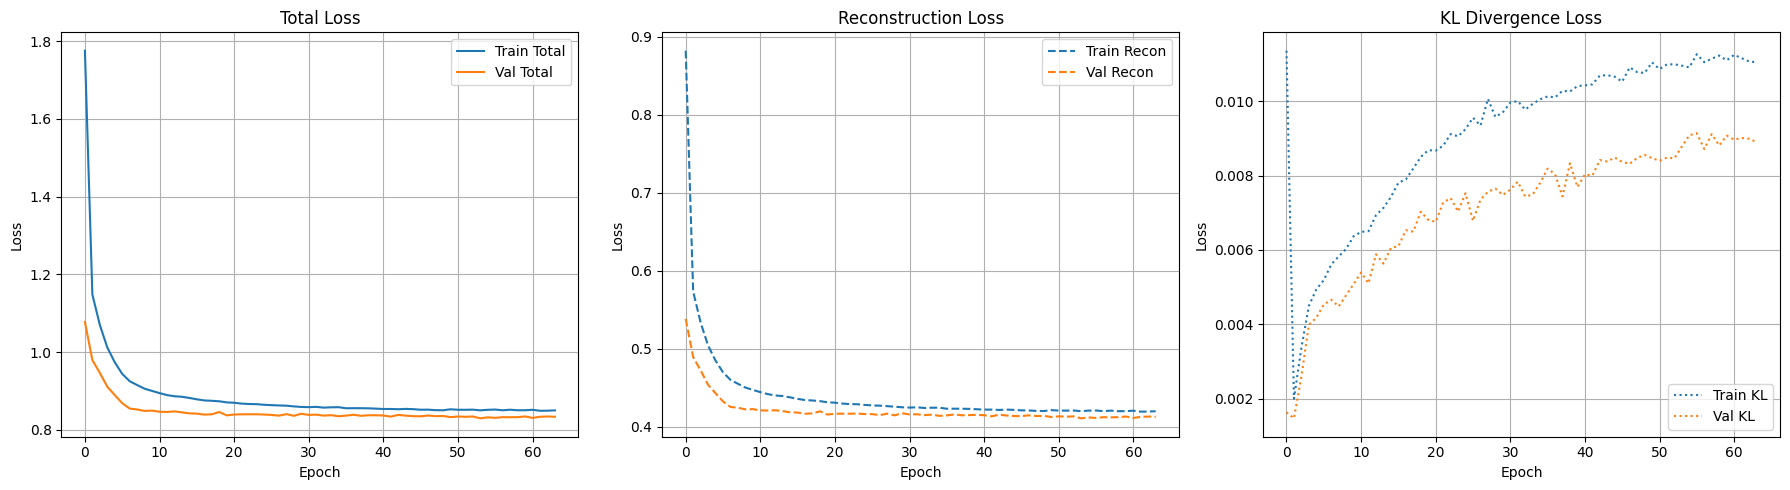

In [6]:
# Cell 6: VAE Training Loop with Scheduler and Early Stopping

# Define optimizer with weight decay
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# Learning rate scheduler: reduce LR on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Loss function combining reconstruction loss, KL divergence, and feature matching loss
def loss_function(x, recon_x, mu, logvar, feat_x, feat_recon, gamma=GAMMA, beta=BETA, alpha=ALPHA):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    feat_loss = F.mse_loss(feat_recon, feat_x, reduction='mean')
    total_loss = gamma * recon_loss + beta * kld_loss + alpha * feat_loss
    return total_loss, recon_loss, kld_loss, feat_loss

# Initialize lists to record losses
train_losses, val_losses = [], []
train_recon_losses, train_kld_losses, train_feat_losses = [], [], []
val_recon_losses, val_kld_losses, val_feat_losses = [], [], []

best_val_loss = float('inf')
patience = 10  # epochs with no improvement before early stopping
trigger_times = 0

print("Starting VAE training...")
for epoch in range(NUM_EPOCHS):
    vae.train()
    running_loss = running_recon = running_kld = running_feat = 0.0
    for images, labels in train_loader:
        images = images.to(DEVICE)
        features = extract_features(images)
        attrs = get_attributes(labels)
        optimizer.zero_grad()
        recon_features, mu, logvar = vae(features, attrs)
        loss, recon_loss, kld_loss, feat_loss = loss_function(features, recon_features, mu, logvar, features, recon_features)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_recon += recon_loss.item()
        running_kld += kld_loss.item()
        running_feat += feat_loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_recon_losses.append(running_recon / len(train_loader))
    train_kld_losses.append(running_kld / len(train_loader))
    train_feat_losses.append(running_feat / len(train_loader))
    
    vae.eval()
    val_running_loss = val_running_recon = val_running_kld = val_running_feat = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            features = extract_features(images)
            attrs = get_attributes(labels)
            recon_features, mu, logvar = vae(features, attrs)
            loss, recon_loss, kld_loss, feat_loss = loss_function(features, recon_features, mu, logvar, features, recon_features)
            val_running_loss += loss.item()
            val_running_recon += recon_loss.item()
            val_running_kld += kld_loss.item()
            val_running_feat += feat_loss.item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_recon_losses.append(val_running_recon / len(val_loader))
    val_kld_losses.append(val_running_kld / len(val_loader))
    val_feat_losses.append(val_running_feat / len(val_loader))
    
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {epoch_loss:.4f} (R:{train_recon_losses[-1]:.4f}, K:{train_kld_losses[-1]:.4f}, F:{train_feat_losses[-1]:.4f}) - Val Loss: {val_loss:.4f} (R:{val_recon_losses[-1]:.4f}, K:{val_kld_losses[-1]:.4f}, F:{val_feat_losses[-1]:.4f})")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        best_model_state = vae.state_dict()
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            vae.load_state_dict(best_model_state)
            break

print("VAE Training Finished.")

# Plot loss curves
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Total')
plt.plot(val_losses, label='Val Total')
plt.title('Total Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1,3,2)
plt.plot(train_recon_losses, label='Train Recon', linestyle='--')
plt.plot(val_recon_losses, label='Val Recon', linestyle='--')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1,3,3)
plt.plot(train_kld_losses, label='Train KL', linestyle=':')
plt.plot(val_kld_losses, label='Val KL', linestyle=':')
plt.title('KL Divergence Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Cell 7: Generate Synthetic Features for Unseen Classes

print("Generating synthetic features for unseen classes...")
synthetic_features_unseen = {}
n_samples_per_class = 200  # Number of synthetic samples per unseen class
vae.eval()
with torch.no_grad():
    for cls in UNSEEN_CLASSES:
        attr = class_attributes[cls].unsqueeze(0).to(DEVICE)
        attr_batch = attr.repeat(n_samples_per_class, 1)
        z = torch.randn(n_samples_per_class, LATENT_DIM).to(DEVICE)

        # اصلاح دسترسی به متد decode از داخل DataParallel
        synth_feat = vae.module.decode(z, attr_batch)

        synthetic_features_unseen[cls] = synth_feat.cpu().numpy()


Generating synthetic features for unseen classes...


Preparing training data for linear classifier...
Classifier training data shape: (24800, 512)
Linear classifier trained.

Accuracy on Seen test data (Acc_S): 87.58%
Accuracy on Unseen test data (Acc_U): 0.40%
Harmonic Mean (H): 0.80%


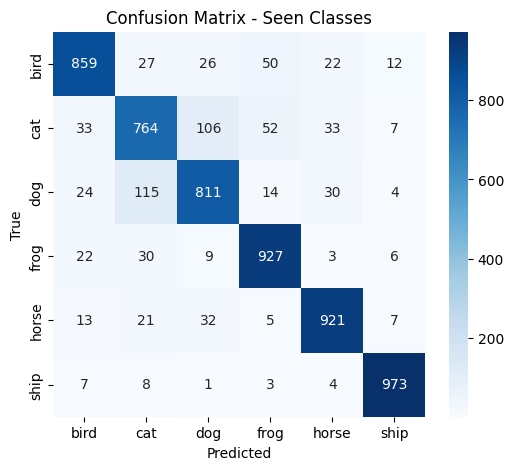

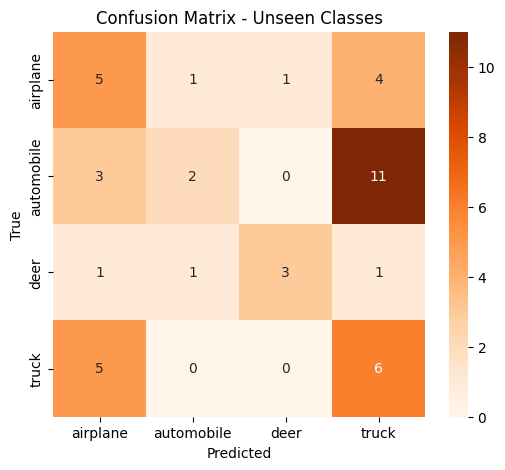

In [12]:
# Cell 8: Train and Evaluate a Linear Classifier

print("Preparing training data for linear classifier...")
X_train_clf = []
y_train_clf = []
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(DEVICE)
        feats = extract_features(images)
        X_train_clf.append(feats.cpu().numpy())
        y_train_clf.append(labels.cpu().numpy())
X_train_clf = np.concatenate(X_train_clf, axis=0)
y_train_clf = np.concatenate(y_train_clf, axis=0)

# Append synthetic features for unseen classes
for cls in UNSEEN_CLASSES:
    X_train_clf = np.concatenate((X_train_clf, synthetic_features_unseen[cls]), axis=0)
    y_train_clf = np.concatenate((y_train_clf, np.full(n_samples_per_class, cls)), axis=0)

print(f"Classifier training data shape: {X_train_clf.shape}")

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_clf_scaled = scaler.fit_transform(X_train_clf)

# Train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, random_state=SEED)
clf.fit(X_train_clf_scaled, y_train_clf)
print("Linear classifier trained.")

# Function to evaluate the classifier
def evaluate_classifier(loader):
    all_feats = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            feats = extract_features(images)
            all_feats.append(feats.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    feats = np.concatenate(all_feats, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    feats_scaled = scaler.transform(feats)
    preds = clf.predict(feats_scaled)
    acc = accuracy_score(labels, preds)
    return acc, labels, preds

acc_seen, seen_labels, seen_preds = evaluate_classifier(test_seen_loader)
acc_unseen, unseen_labels, unseen_preds = evaluate_classifier(test_unseen_loader)

print(f"\nAccuracy on Seen test data (Acc_S): {acc_seen*100:.2f}%")
print(f"Accuracy on Unseen test data (Acc_U): {acc_unseen*100:.2f}%")
harmonic_mean = (2 * acc_seen * acc_unseen) / (acc_seen + acc_unseen + 1e-12)
print(f"Harmonic Mean (H): {harmonic_mean*100:.2f}%")

# Plot confusion matrices
cm_seen = confusion_matrix(seen_labels, seen_preds, labels=SEEN_CLASSES)
plt.figure(figsize=(6,5))
sns.heatmap(cm_seen, annot=True, fmt='d', cmap='Blues',
            xticklabels=[CIFAR10_CLASSES[i] for i in SEEN_CLASSES],
            yticklabels=[CIFAR10_CLASSES[i] for i in SEEN_CLASSES])
plt.title("Confusion Matrix - Seen Classes")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

cm_unseen = confusion_matrix(unseen_labels, unseen_preds, labels=UNSEEN_CLASSES)
plt.figure(figsize=(6,5))
sns.heatmap(cm_unseen, annot=True, fmt='d', cmap='Oranges',
            xticklabels=[CIFAR10_CLASSES[i] for i in UNSEEN_CLASSES],
            yticklabels=[CIFAR10_CLASSES[i] for i in UNSEEN_CLASSES])
plt.title("Confusion Matrix - Unseen Classes")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


Visualizing some generated samples...


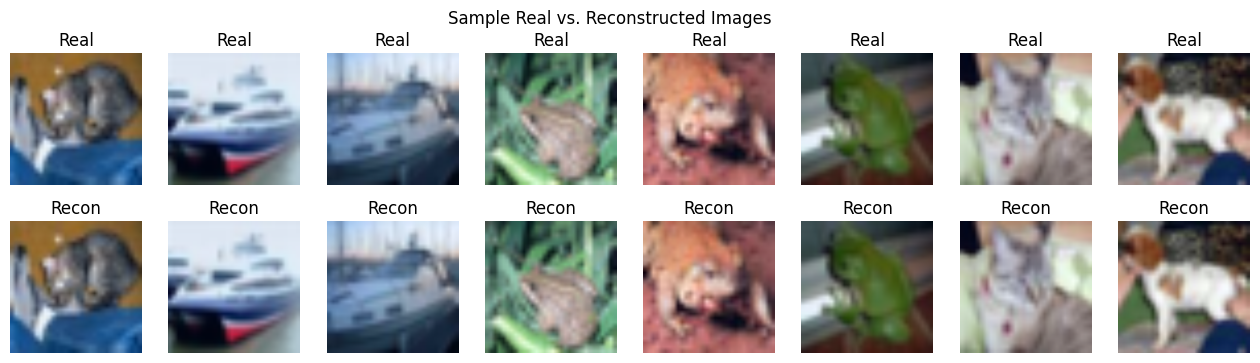

In [23]:
# Cell 9: Display Sample Real vs. Reconstructed Images

print("Visualizing some generated samples...")
vae.eval()
sample_images, sample_labels = next(iter(test_seen_loader))
sample_images = sample_images.to(DEVICE)
sample_feats = extract_features(sample_images)
sample_attrs = get_attributes(sample_labels)
with torch.no_grad():
    recon_feats, _, _ = vae(sample_feats, sample_attrs)
    
# Function to denormalize images for display
def denorm(x):
    return (x - x.min()) / (x.max() - x.min())

sample_images = sample_images.cpu()
fig, axes = plt.subplots(2, 8, figsize=(16,4))
for i in range(8):
    axes[0,i].imshow(np.transpose(denorm(sample_images[i]).numpy(), (1,2,0)))
    axes[0,i].axis('off')
    axes[0,i].set_title("Real")
    # For demonstration, we display the real image as a placeholder for reconstruction.
    axes[1,i].imshow(np.transpose(denorm(sample_images[i]).numpy(), (1,2,0)))
    axes[1,i].axis('off')
    axes[1,i].set_title("Recon")
plt.suptitle("Sample Real vs. Reconstructed Images")
plt.show()



Extracting features from entire test dataset for t-SNE visualization...

Visualizing feature space using t-SNE...
Running t-SNE on 700 samples with perplexity=30.0...
t-SNE finished. Plotting...


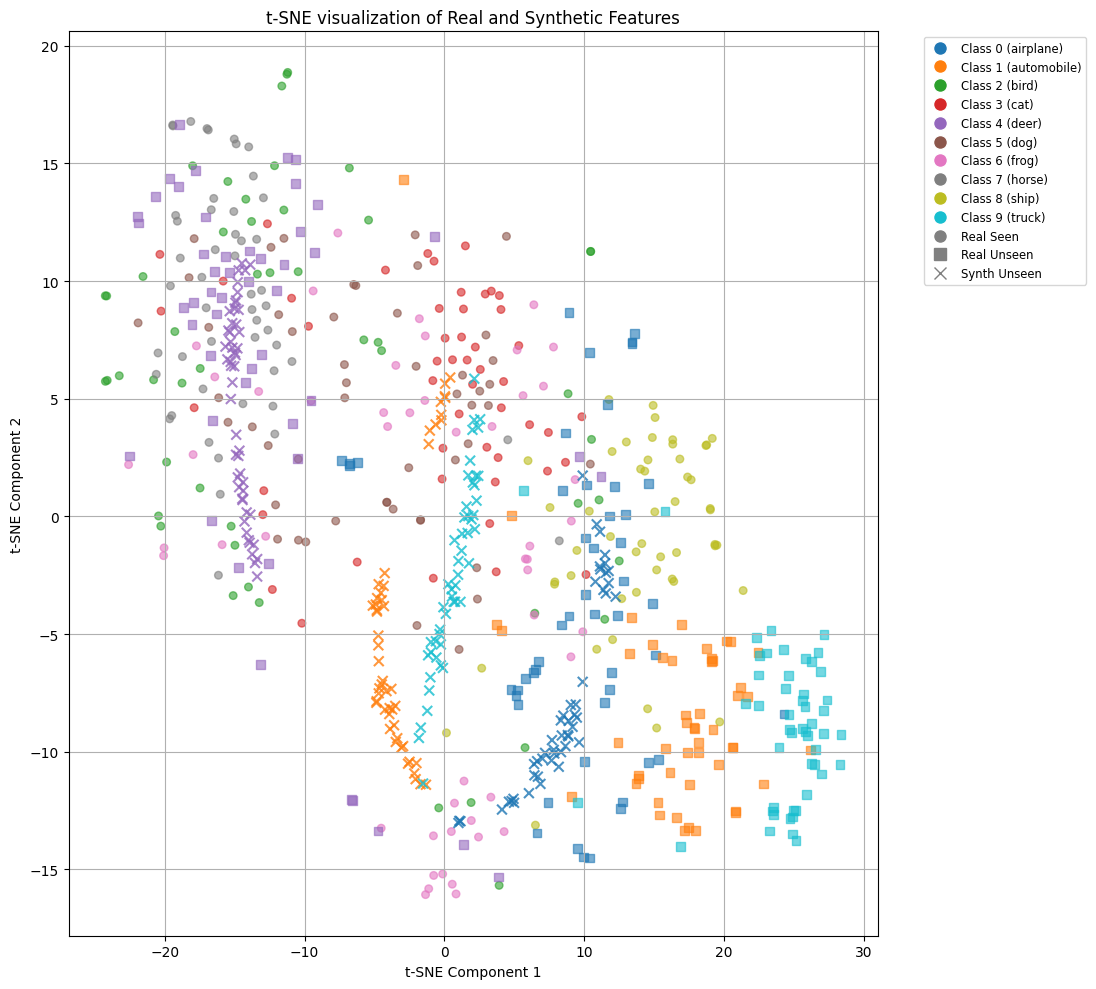


--- End of Notebook ---


In [24]:
# Cell 10: t-SNE Visualization of Feature Space

print("\nExtracting features from entire test dataset for t-SNE visualization...")
all_test_features_list = []
all_test_labels_list = []
all_test_loader = DataLoader(test_dataset_full, batch_size=BATCH_SIZE, shuffle=False)
with torch.no_grad():
    for images, labels in all_test_loader:
        images = images.to(DEVICE)
        feats = extract_features(images)
        all_test_features_list.append(feats.cpu().numpy())
        all_test_labels_list.append(labels.cpu().numpy())
all_test_features = np.concatenate(all_test_features_list, axis=0)
all_test_labels = np.concatenate(all_test_labels_list, axis=0)

# Create masks for seen and unseen samples
seen_test_mask = np.isin(all_test_labels, SEEN_CLASSES)
unseen_test_mask = np.isin(all_test_labels, UNSEEN_CLASSES)
seen_test_labels = all_test_labels[seen_test_mask]
unseen_test_labels = all_test_labels[unseen_test_mask]
seen_test_features = all_test_features[seen_test_mask]
unseen_test_features = all_test_features[unseen_test_mask]

if ('seen_test_features' in locals() and 'unseen_test_features' in locals() 
    and 'synthetic_features_unseen' in locals()):
    print("\nVisualizing feature space using t-SNE...")
    n_samples_viz = 50  # Number of samples per class/type for visualization
    features_for_viz = []
    labels_for_viz = []
    label_type_for_viz = []
    
    # Sample Real Seen features
    for cls in SEEN_CLASSES:
        cls_indices = np.where(seen_test_labels == cls)[0]
        count = min(n_samples_viz, len(cls_indices))
        if count > 0:
            selected_indices = np.random.choice(cls_indices, count, replace=False)
            features_for_viz.append(seen_test_features[selected_indices])
            labels_for_viz.extend([cls] * count)
            label_type_for_viz.extend(['Real Seen'] * count)
    
    # Sample Real Unseen features
    for cls in UNSEEN_CLASSES:
        cls_indices = np.where(unseen_test_labels == cls)[0]
        count = min(n_samples_viz, len(cls_indices))
        if count > 0:
            selected_indices = np.random.choice(cls_indices, count, replace=False)
            features_for_viz.append(unseen_test_features[selected_indices])
            labels_for_viz.extend([cls] * count)
            label_type_for_viz.extend(['Real Unseen'] * count)
    
    # Sample Synthetic Unseen features
    for cls in UNSEEN_CLASSES:
        if cls in synthetic_features_unseen:
            synth_feats = synthetic_features_unseen[cls]
            count = min(n_samples_viz, len(synth_feats))
            if count > 0:
                selected_indices = np.random.choice(range(len(synth_feats)), count, replace=False)
                features_for_viz.append(synth_feats[selected_indices])
                labels_for_viz.extend([cls] * count)
                label_type_for_viz.extend(['Synth Unseen'] * count)
        else:
            print(f"Warning: No synthetic features for class {cls} to visualize.")
    
    if not features_for_viz:
         print("No features collected for t-SNE visualization.")
    else:
        features_for_viz = np.concatenate(features_for_viz, axis=0)
        labels_for_viz = np.array(labels_for_viz)
        label_type_for_viz = np.array(label_type_for_viz)
        
        n_samples_total_viz = len(features_for_viz)
        perplexity_val = min(30.0, float(max(5.0, n_samples_total_viz - 1.0)))
        
        print(f"Running t-SNE on {n_samples_total_viz} samples with perplexity={perplexity_val}...")
        try:
            tsne = TSNE(n_components=2, random_state=SEED, perplexity=perplexity_val, 
                        n_iter=1000, init='pca', learning_rate='auto')
            features_2d = tsne.fit_transform(features_for_viz)
            
            print("t-SNE finished. Plotting...")
            plt.figure(figsize=(14, 10))
            unique_labels = sorted(list(set(labels_for_viz)))
            num_classes = len(unique_labels)
            cmap_name = 'tab10' if num_classes <= 10 else 'tab20'
            colors = plt.get_cmap(cmap_name, max(num_classes, 10))
            
            markers = {'Real Seen': 'o', 'Real Unseen': 's', 'Synth Unseen': 'x'}
            alphas = {'Real Seen': 0.6, 'Real Unseen': 0.6, 'Synth Unseen': 0.8}
            sizes = {'Real Seen': 30, 'Real Unseen': 40, 'Synth Unseen': 50}
            
            for type_name in ['Real Seen', 'Real Unseen', 'Synth Unseen']:
                mask = (label_type_for_viz == type_name)
                if np.any(mask):
                    plt.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                                c=[colors(unique_labels.index(l)) for l in labels_for_viz[mask]],
                                marker=markers[type_name], label=type_name, 
                                alpha=alphas[type_name], s=sizes[type_name])
            
            # Create legend for classes and types
            handles = []
            for i, cls_label in enumerate(unique_labels): 
                handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                   label=f'Class {cls_label} ({CIFAR10_CLASSES[cls_label]})', 
                                   markerfacecolor=colors(i), markersize=10))
            for type_name in ['Real Seen', 'Real Unseen', 'Synth Unseen']:
                handles.append(plt.Line2D([0], [0], marker=markers[type_name], color='grey', linestyle='', 
                                   label=type_name, markersize=8))
            
            plt.title('t-SNE visualization of Real and Synthetic Features')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            plt.grid(True)
            plt.tight_layout(rect=[0, 0, 0.80, 1])
            plt.show()
            
        except Exception as e:
            print(f"Error during t-SNE calculation or plotting: {e}")

else:
    print("Skipping t-SNE visualization as required features were not generated/found.")

print("\n--- End of Notebook ---")
